### Run once, to check environment

In [1]:
#!pip3 install -r requirements.txt

### Download Data, put under root directory DM-project/

https://msnews.github.io/behaviors

### Scraper part, no need to run, just in case, can be adapted to other datasource
* Scraping publish time of news.

* To run it, put 'MINDlarge_train' in the top level directory of the project, which is 'DM-project'
  * don't submit MINDlarge_train, add it to gitignore

* Output filepath is 'DM-project/generate/newstimes.csv'

* Don't forget to go back to the top level directory

In [2]:
#%cd scraper

In [3]:
#!scrapy crawl news

In [4]:
#%cd ..

In [5]:
#newsTimes = 'generate/newstimes.csv'

### Load Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

### Preprocssing, run once

In [7]:
#from preprocessing.preprocessing import createNews,createUsers,splitFiles,createCategoriyEmbeddingNLP

In [7]:
#behaviors = 'MINDlarge_train/behaviors.tsv'
news = 'MINDlarge_train/news.tsv'
#entityEmbedding = 'MINDlarge_train/entity_embedding.vec'

#generate news_embedding.csv, news_cleaned.csv
#createNews(news,newsTimes,entityEmbedding)

#generate user_history.csv, user_impression.csv
#createUsers(behaviors)

#split big files
#splitFiles('generate/user_history.csv')
#splitFiles('generate/user_impressions.csv')

### No need to run, already generated, but in case you want to play around.
* generate/news_subcat_embedding_nlp.csv

In [9]:
#!pip3 install spacy

In [10]:
#!python3 -m spacy download en_core_web_lg

In [11]:
#subcategories = "generate/news_subcategories.csv"
#createCategoriyEmbeddingNLP(subcategories)

In [1]:
from analysis.measurement import measurement,baselineTest
from analysis.clustering import clusteringBatch
from analysis.recommendation import searchKNearestNeighbors

In [3]:
t0 = 1575586800+1000
lam = 0.01
threshold = 0.85

#distance bound by radius_scale*std of cluster 
default_radius = 0.3
radius_scale = 1

history = 'generate/user_history_1.csv'
impression = 'generate/user_impressions_1.csv'

### User representation
* clusteringBatch 
     -  group user by UID
     -  perform ward clustering on each user's reading history
     -  sample 3 cluster according to the Importance Scores
     -  calculate the medoid/centroid as one of representation of user's interest
     -  calculate accepted boundary(radius) for each cluster

In [4]:
df_user_representation_medoid,df_user_representation_centroid = clusteringBatch(history,t0,threshold=threshold,lam=lam,default_radius=default_radius,radius_scale=radius_scale,with_centroid=True)

<AxesSubplot:>

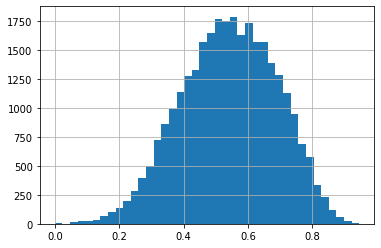

In [6]:
df_user_representation_centroid[~(df_user_representation_centroid.radius==default_radius)].radius.hist(bins=40)

* measurement
  - compare user representation(n by 300) with user impression(m by 300) 
  - get n by m distance matrix
  - mask distance matrix with accepted boundary
  - count recall for each positive impression, divide by length of impressions
  - count hits for each representation, consider empty hits percentage.

### Medoid vs. Centroid

In [14]:
df_measure_centroid = measurement(impression,df_user_representation_centroid)

In [16]:
mean_recall = df_measure_centroid.recall.mean()
empty_percent = df_measure_centroid.percent_empty.mean()

print("If use centroids as user representation, get recall %.2f, the percentage of empty recommendation is %.2f"%(mean_recall,empty_percent))

If use centroids as user representation, get recall 0.56, the percentage of empty recommendation is 0.56


In [17]:
df_measure_medoid = measurement(impression,df_user_representation_medoid)

In [18]:
mean_recall = df_measure_medoid.recall.mean()
empty_percent = df_measure_medoid.percent_empty.mean()

print("If use medoids as user representation, get recall %.2f, the percentage of empty recommendation is %.2f"%(mean_recall,empty_percent))

If use medoids as user representation, get recall 0.50, the percentage of empty recommendation is 0.60


### Baseline Test
   * randomly draw 3 news from history
   * pick the latest 3 news from history

In [19]:
df_user_representation_random,df_user_representation_latest = baselineTest(history,default_radius=default_radius)

In [24]:
df_measure_random = measurement(impression,df_user_representation_random)

In [25]:
mean_recall = df_measure_random.recall.mean()
empty_percent = df_measure_random.percent_empty.mean()

print("If randomly draw 3 samples, get recall %.2f, the percentage of empty recommendation is %.2f"%(mean_recall,empty_percent))

If randomly draw 3 samples, get recall 0.19, the percentage of empty recommendation is 0.84


In [26]:
df_measure_lastest = measurement(impression,df_user_representation_latest)

In [27]:
mean_recall = df_measure_lastest.recall.mean()
empty_percent = df_measure_lastest.percent_empty.mean()

print("If draw 3 latests samples, get recall %.2f, the percentage of empty recommendation is %.2f"%(mean_recall,empty_percent))

If draw 3 latests samples, get recall 0.19, the percentage of empty recommendation is 0.83


### Recommendation System--Hierarchical Navigable Small World

* 89222 elements in space, with 100 dimensions.

* Search 4 nearest neighbor for each item of user representation

In [5]:
import time

t0 = time.perf_counter()
df_recommendation = searchKNearestNeighbors(df_user_representation_centroid,k=4)

print(f'Time cost {time.perf_counter()-t0} s')

Time cost 20.930753366000005 s


In [14]:
df_news_meta = pd.read_csv(news,sep='\t',header=None)
df_news_meta.rename(columns={0:'NID',1:'category',2:'subcategory',3:'title',4:'abstract',6:'title_entities',7:'abstract_entities'},inplace=True)
df_news_meta = df_news_meta[['NID','category','subcategory','title','abstract','title_entities','abstract_entities']]


In [18]:
UID = df_recommendation.sample().UID.values[0]
df_recommendation[df_recommendation.UID==UID].merge(df_news_meta,on='NID')

,UID,NID,category,subcategory,title,abstract,title_entities,abstract_entities
0,U424009,N9543,health,health-news,Meghan McCain says she leaned on 'View' co-hos...,The View co-host Meghan McCain continues to ha...,"[{""Label"": ""Meghan McCain"", ""Type"": ""P"", ""Wiki...","[{""Label"": ""Meghan McCain"", ""Type"": ""P"", ""Wiki..."
1,U424009,N81283,video,popculture,Meghan McCain GOES IN on Donald Trump Jr. on '...,The daytime talk show co-host sparred with the...,"[{""Label"": ""Meghan McCain"", ""Type"": ""P"", ""Wiki...",[]
2,U424009,N120617,video,news,Donald Trump Jr. and Meghan McCain face off on...,Meghan McCain confronted Donald Trump Jr. abou...,"[{""Label"": ""Meghan McCain"", ""Type"": ""P"", ""Wiki...","[{""Label"": ""Meghan McCain"", ""Type"": ""P"", ""Wiki..."
3,U424009,N100397,video,news,Donald Trump Jr. appeared on 'The View' to pro...,"Donald Trump, Jr. appeared on 'The View' to pr...","[{""Label"": ""The View (talk show)"", ""Type"": ""W""...","[{""Label"": ""The View (talk show)"", ""Type"": ""W""..."
4,U424009,N128648,entertainment,celebrity,"Lady Gaga, Jim Carrey, Christina Hendricks and...","A wave of pre-holiday breakups rock Hollywood,...","[{""Label"": ""Jim Carrey"", ""Type"": ""P"", ""Wikidat...",[]
5,U424009,N88075,entertainment,celebrity,Ben Affleck has a new girlfriend after using t...,"Meg Ryan and John Mellencamp call it quits, Ha...","[{""Label"": ""Ben Affleck"", ""Type"": ""P"", ""Wikida...","[{""Label"": ""Meg Ryan"", ""Type"": ""P"", ""WikidataI..."
6,U424009,N12390,entertainment,entertainment-celebrity,Lily Allen and David Harbour Share Smooches in...,"Star Tracks: Saturday, October 19, 2019","[{""Label"": ""Jennifer Garner"", ""Type"": ""P"", ""Wi...",[]
7,U424009,N23293,tv,tv-celebrity,Blake Lively Seen Out With Ryan Reynolds for t...,Check out the brand new photo of the mother of...,"[{""Label"": ""Ryan Reynolds"", ""Type"": ""P"", ""Wiki...",[]
8,U424009,N116078,weather,weathertopstories,Arctic blast spreads shivers from Maine to Dee...,"PORTLAND, Maine (AP) An arctic blast that se...","[{""Label"": ""Maine"", ""Type"": ""G"", ""WikidataId"":...","[{""Label"": ""Maine"", ""Type"": ""G"", ""WikidataId"":..."
9,U424009,N58030,news,newspolitics,Bay Briefing: Why do presidential candidates s...,"Good morning, Bay Area. It's Thursday, Nov. 14...","[{""Label"": ""California"", ""Type"": ""G"", ""Wikidat...","[{""Label"": ""1978 California Proposition 13"", ""..."


In [19]:
df_history = pd.read_csv(history)

df_history[df_history.UID==UID].merge(df_news_meta,on='NID')

,UID,NID,category,subcategory,title,abstract,title_entities,abstract_entities
0,U424009,N96605,health,nutrition,23 Foods That Help Lower High Blood Pressure,Consuming less sodium may be important to help...,"[{""Label"": ""Hypertension"", ""Type"": ""C"", ""Wikid...","[{""Label"": ""Hypertension"", ""Type"": ""C"", ""Wikid..."
1,U424009,N33154,foodanddrink,tipsandtricks,The Best Canned Tomatoes: Which Brands Taste S...,"So long summer, hello canned tomato season.",[],[]
2,U424009,N109120,news,newspolitics,Former US national security expert on Russia e...,"Fiona Hill, a former top U.S. national securit...","[{""Label"": ""Russia"", ""Type"": ""G"", ""WikidataId""...","[{""Label"": ""Fiona Hill (presidential advisor)""..."
3,U424009,N109270,lifestyle,lifestylebuzz,Pictures so perfect it's hard to believe they'...,Photos taken by people from across the world t...,[],[]
4,U424009,N11379,finance,finance-home-loans,Is buying an abandoned property a good investm...,Is abandoned property a good buy?,[],[]
5,U424009,N62613,movies,movievideo,Trailer - Onward,Trailer 2,[],[]
6,U424009,N79938,entertainment,entertainment-celebrity,How tall are your favorite male stars?,"Alexander Skarsgard, Bruno Mars and more celeb...",[],"[{""Label"": ""Alexander Skarsg\u00e5rd"", ""Type"":..."
7,U424009,N117275,lifestyle,lifestylebuzz,Hawk Can't Understand Why This Little 'Bunny' ...,This fearsome bird of prey has clearly never m...,[],[]
8,U424009,N63067,lifestyle,lifestyledidyouknow,Discover the abandoned circus-themed house clo...,Hidden deep in a valley in New York's Catskill...,[],"[{""Label"": ""Catskill Mountains"", ""Type"": ""L"", ..."
9,U424009,N49511,finance,finance-real-estate,$42 million price cut on tech billionaire's Si...,Silicon Valley big shot Scott McNealy drastica...,"[{""Label"": ""Silicon Valley"", ""Type"": ""G"", ""Wik...","[{""Label"": ""Scott McNealy"", ""Type"": ""P"", ""Wiki..."
